## Feature selection

This notebook uses Random Forest models to narrow down features for predicting injury proportions and damage.

__Current Approach__

For predicting both injury proportion and damage:
1. Fit a Random Forest with default parameters
2. Drop features below a certain importance threshold
3. Repeat steps 1 and 2 as needed

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier, XGBRegressor

from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show

In [37]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')

In [38]:
data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'wind_vel_kts', 'gust_kts',
       'altimeter', 'ev_highest_injury', 'ev_inj_tot_f', 'ev_inj_tot_m',
       'ev_inj_tot_n', 'ev_inj_tot_s', 'ev_inj_tot_t', 'aircraft_count',
       'Aircraft_ID', 'event_key', 'damage', 'total_seats', 'num_eng',
       'acft_fatal_count', 'acft_minor_count', 'acft_none_count',
       'acft_serious_count', 'acft_total_person_count',
       'acft_injured_person_count', 'insp_date', 'event_date',
       'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_pa

# Exploring Survivorship Bias

(array([8847.,  468., 2015.,   77.,  303., 1231.,   17.,   34.,  211.,
        2330.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

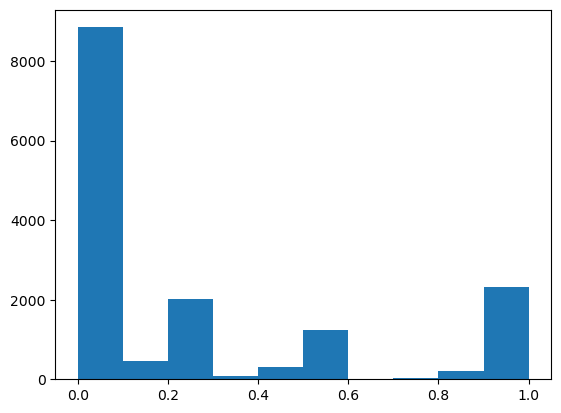

In [39]:
data['crash_severity_index'] = (data['acft_prop_inj_m']* 0.2
                                + data['acft_prop_inj_s']*0.6
                                + data['acft_prop_inj_f'] *1)

plt.hist(data['crash_severity_index'])

In [40]:
data['wind_vel_kts'].isna().sum()/len(data)

np.float64(0.21431329643454755)

In [46]:
feature = 'gust_kts'
feature_known = feature+'_known'
data[feature_known] = data[feature]!=0

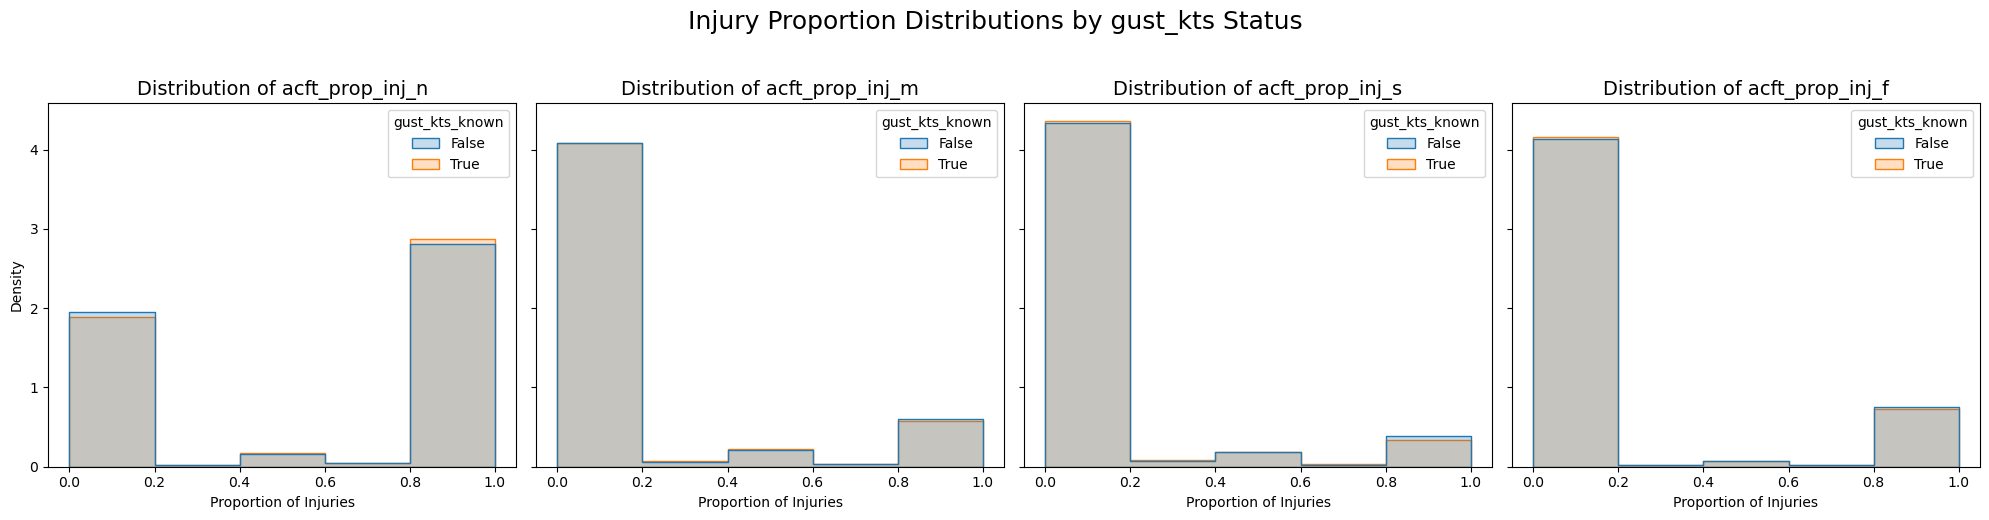

In [47]:
## Thank you Gemini 2.5 Pro for this code :-)

target_columns = ['acft_prop_inj_n', 'acft_prop_inj_m', 'acft_prop_inj_s', 'acft_prop_inj_f']

# Create a 1x4 grid of subplots. `sharey=True` makes the y-axis consistent.
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Loop through each target column and its corresponding subplot axis
for ax, col in zip(axes, target_columns):
    sns.histplot(
        data=data,
        bins=5,
        x=col,
        hue=feature_known,  # This creates the two overlaid histograms
        #kde=True,                 # Adds a density curve for better shape comparison
        stat='density',           # Normalizes histograms to compare shapes, not counts
        common_norm=False,        # Normalizes each histogram independently
        element='step',           # Use steps instead of bars for cleaner overlaps
        ax=ax                     # Specifies which subplot to draw on
    )
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel('Proportion of Injuries') # Set a clear x-axis label

# Add a main title for the entire figure
fig.suptitle(f'Injury Proportion Distributions by {feature} Status', fontsize=18, y=1.03)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

<Axes: >

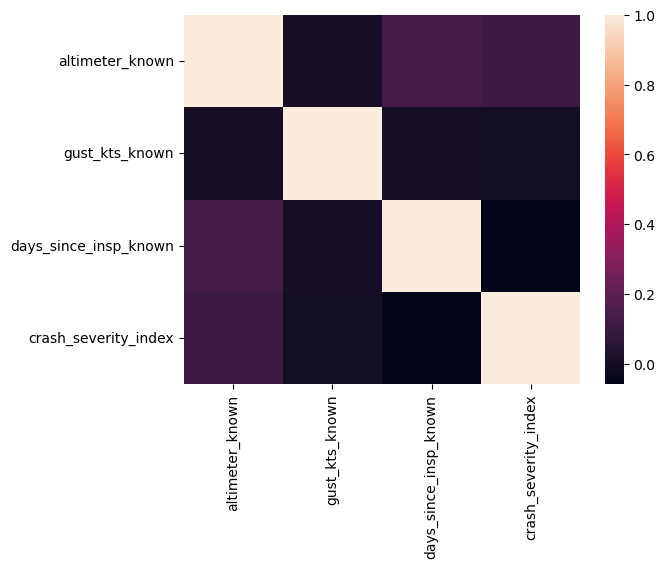

In [29]:
cols = ['altimeter_known','gust_kts_known', 'days_since_insp_known', 'crash_severity_index']

sns.heatmap(data[cols].corr())

### Takeaway of the plot above

- Known altimeter reading correlates positively with crash severity
- Known date of most recent inspection correlates negatively with crash severity
- Known gust speed does not correlate with crash severity
- 

# Modeling

In [ ]:
features = ['latitude', 'longitude',    #need to change to numeric value first
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown', 'acft_total_person_count']

### Functions for random forests

In [7]:
def print_sorted_feature_importances(feat_imps):
    '''
    Takes a dictionary with items 
        feature_name: feature_importance
    and prints the feature name/importance pairs in decreasing order

    Solution taken from https://stackoverflow.com/questions/11228812/print-a-dict-sorted-by-values
    '''
    sorted_feat_imps = sorted( ((imp,feat) for feat,imp in feat_imps.items()), reverse=True)
    for imp,feat in sorted_feat_imps:
        print(f'{feat} importance: {imp}')

In [8]:
def rf_important_features(X,y,features,model=RandomForestRegressor,alpha=0.01,n_estimators=500,max_depth=10):
    '''
    Fit the model on X,y and return a list of features with importance above alpha
    Inputs:
        X: feature data (pd.DataFrame)
        y: target data (pd.Series)
        model: RandomForestRegressor or RandomForestClassifier
        alpha: importance threshold (float)
        n_estimators: number of estimators in RandomForest
        max_dept: max depth of tree in RandomForest
    '''
    rf = model(n_estimators=n_estimators, max_depth=max_depth)
    rf.fit(X, y)

    feat_importances = {}

    for i, feature in enumerate(features):
        feat_importances[feature] = rf.feature_importances_[i]

    important_feats = [feature for feature in feat_importances.keys() if feat_importances[feature] > alpha]

    return important_feats

### Fitting RandomForests

In [32]:
# Define the target and model
target = 'acft_prop_inj_f'
rf = RandomForestRegressor

available_data = data[~data[target].isna()]

X = available_data[features]
y = available_data[target]

# Use for categorical target
# le = LabelEncoder()
# y = le.fit_transform(y)

In [33]:
# Get the important features
important_features = rf_important_features(X,y,features,model=rf,alpha=0.015)
X_small = available_data[important_features]

In [ ]:
# GridSearch 
param_grid = {
    'n_estimators': [50,100,150,200,250,300,350,400,450,500],
    'max_depth': [7]
}

grid = GridSearchCV(
    rf(),
    param_grid,
    cv=5,
)

grid.fit(X_small,y)

In [12]:
# best_rf = grid.best_estimator_

# results = grid.cv_results_
# plt.plot(results['param_n_estimators'], results['mean_test_score'])
# plt.show()

### XGBoost

In [27]:
xgb = XGBClassifier()

# GridSearch 
param_grid = {
    'n_estimators': [20,200,2000],
    'learning_rate': [0.2, 0.5,1],
    'max_depth': [3,5,7]
}

grid = GridSearchCV(
    xgb,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_small,y)

,estimator,"XGBClassifier...ate=None, ...)"
,param_grid,"{'learning_rate': [0.2, 0.5, ...], 'max_depth': [3, 5, ...], 'n_estimators': [20, 200, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [28]:
results = pd.DataFrame(grid.cv_results_)

# You can display the relevant columns to check
print("Grid Search Results DataFrame:")
print(results[['param_max_depth', 'param_learning_rate', 'mean_test_score']].head())
print("-" * 30)


# 2. Pivot the data to create the matrix for the heatmap
#    (The only change from the last example is 'param_n_estimators' -> 'param_learning_rate')
scores = results.pivot(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')

print("Pivoted Scores for Heatmap:")
print(scores)
print("-" * 30)


# 3. Plot the heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    scores,
    annot=True,      # Show the scores in each cell
    fmt=".3f",       # Format the scores to 3 decimal places
    cmap='plasma',   # A different colormap for variety
    linewidths=.5
)
plt.title('Grid Search CV Mean Test Scores (XGBoost)', fontsize=16)
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('max_depth', fontsize=12)
plt.show()

Grid Search Results DataFrame:
   param_max_depth  param_learning_rate  mean_test_score
0                3                  0.2         0.317343
1                3                  0.2         0.364232
2                3                  0.2         0.389619
3                5                  0.2         0.344234
4                5                  0.2         0.374193
------------------------------


ValueError: Index contains duplicate entries, cannot reshape

In [15]:
best_xgb = grid.best_estimator_

In [16]:
data_train, data_val = train_test_split(available_data, test_size=0.2, shuffle=True)

X_tr = data_train[important_features]
y_tr = data_train[target]
X_val = data_val[important_features]
y_val = data_val[target]

#use for categorical data
y_tr = le.transform(y_tr)
y_val = le.transform(y_val)

best_xgb.fit(X_tr, y_tr)
preds = best_xgb.predict(X_val)
# plt.scatter(y_val, preds, alpha=.05)
# plt.xlabel('Observed y')
# plt.ylabel('Predicted y')
# plt.title('XGB predicted y vs. observed y on validation set')
# plt.show()

confusion_matrix(y_val, preds)

array([[  33,    0,  232],
       [   0,    1,   18],
       [  79,   14, 2598]])

In [17]:
f1_score(y_val, preds, average='macro')

0.3906551024314902

### ExplainableBoostingClassifier

In [ ]:
ebr = ExplainableBoostingRegressor(interactions=0)
ebr.fit(X,y)

show(ebr.explain_global())

/Users/cjargue/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/interpret/glassbox/_ebm/_ebm.py:812: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


<!-- http://127.0.0.1:7001/6470459488/ -->

## Notes

Does it make sense to do some batched feature reduction? E.g. for each of the following categories, the variables seem to be largely overlapping
- Location relative to landing: `BroadPhaseofFlight`, `altimiter`, `apt_dst`
- Aircraft type: `num_eng`, `acft_make`, `acft_category`, `acft_total_person_count`, `far_part`

`gust_kts` seems to be important but there's potentially a large amount of corrupted data in there. Should we keep it in?

How much do we have to worry about outliers if we're using a tree-based ensemble model?

Can try putting the categorical variables into XGBoost without one-hot encoding

I tried iteratively refining the list of important features and it seems like little changes on the second iteration

RandomForestRegressor hyperparameters
- Best max_depth = 7, similarly well for 6-9
- Best n_estimators = 200: the difference is marginal for anything above 50, and miniscule for anything above 200 (the difference seems to change trial-by-trial. Read: not statistically significant)

XGB does a bit better. Still not great.

XGB gets ~0.5 macro F1 on `damage` with 4 categrories, that goes down to ~0.4 if we drop the rows with unknown damage. Pretty bad!

`gust_kts` comes up as a fairly significant factor, but I'm a bit concerned about data leakage since we're missing a lot of the values. It seems plausible that gusts are more likely to be recorded when they're a factor, which may make them appear to be more important than they are

In [19]:
data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'gust_kts', 'altimeter',
       'ev_highest_injury', 'ev_inj_tot_f', 'ev_inj_tot_m', 'ev_inj_tot_n',
       'ev_inj_tot_s', 'ev_inj_tot_t', 'aircraft_count', 'Aircraft_ID',
       'event_key', 'damage', 'num_eng', 'acft_fatal_count',
       'acft_minor_count', 'acft_none_count', 'acft_serious_count',
       'acft_total_person_count', 'acft_injured_person_count', 'insp_date',
       'event_date', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUB

In [20]:
## Approximate number of variables for each feature importance threshold
## This is old code that will no longer run, but the output would be very similar 

# alpha = np.arange(15)/100

# for a in alpha:
#    important_dummies = {item for item in feat_imps.items() if item[1] > a}
#    print(f'Importance threshold {a} -- {len(important_dummies)} variables')

(array([1.26e+04, 2.80e+01, 2.55e+02, 9.40e+02, 5.17e+02, 3.36e+02,
        1.12e+02, 4.50e+01, 2.50e+01, 6.00e+00]),
 array([ 0. ,  4.8,  9.6, 14.4, 19.2, 24. , 28.8, 33.6, 38.4, 43.2, 48. ]),
 <BarContainer object of 10 artists>)

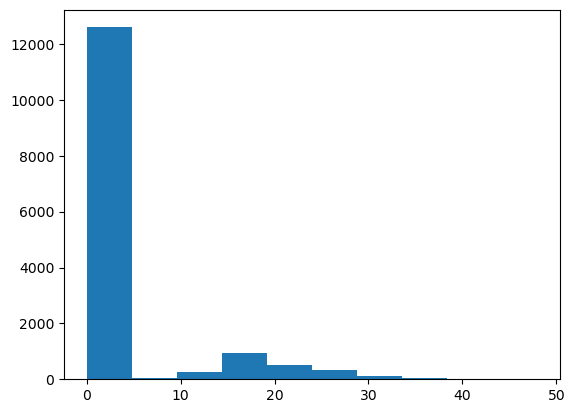

In [23]:
# Histogram of `gust_kts`
# Restricted to < 50 to eliminate an outlier which is a clear mistake

plt.hist(available_data[available_data['gust_kts']<50]['gust_kts'])

In [24]:
available_data['gust_kts'].max()

np.float64(999.0)

In [25]:
## Heatmap of a grid search for parameters of a random forest to predict serious/fatal injury proportion
## Looks like increasing n_estimators doesn't accomplish much and it slows down the training/predicting
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)

# # You can display the first few rows to see the structure
# print("Grid Search Results DataFrame:")
# print(results[['param_max_depth', 'param_n_estimators', 'mean_test_score']].head())
# print("-" * 30)

# # 2. Pivot the data to create a matrix with max_depth as rows and n_estimators as columns
# scores = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# print("Pivoted Scores for Heatmap:")
# print(scores)
# print("-" * 30)


# # 3. Create the heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     scores,
#     annot=True,      # Write the score in each cell
#     fmt=".3f",       # Format the annotations to 3 decimal places
#     linewidths=.5,   # Add lines between cells
#     cmap='viridis'   # Use a visually appealing color map
# )
# plt.title('Grid Search CV Mean Test Scores', fontsize=16)
# plt.xlabel('n_estimators', fontsize=12)
# plt.ylabel('max_depth', fontsize=12)
# plt.show()

In [26]:
## Plot of performance for n_estimators = 100, max_depth = 1,2,3,...,13
## Does best for max_depth = 6-9
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)
# plt.plot(results['param_max_depth'], results['mean_test_score'])
# plt.show()